In [16]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install mplfinance

In [18]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

#Modeling
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import matplotlib.dates as mdates
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

#Evaluation
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

#### 1. Forecasting Saham ADRO

##### Model Prophet

In [21]:
# Load data
adro = pd.read_csv("Stock/ADRO.JK.csv")

# Tambah Kolom Kode Saham
adro['Kode'] = 'ADRO'

# Tampilkan Data
adro

,Date,Open,High,Low,Close,Adj Close,Volume,Kode
0,2008-08-01,1630.0,1680.0,1620.0,1630.0,625.735046,78478500.0,ADRO
1,2008-08-04,1590.0,1630.0,1590.0,1590.0,610.379700,43837000.0,ADRO
2,2008-08-05,1550.0,1580.0,1540.0,1550.0,595.024109,50244500.0,ADRO
3,2008-08-06,1540.0,1570.0,1540.0,1540.0,591.185242,48545500.0,ADRO
4,2008-08-07,1560.0,1570.0,1540.0,1560.0,598.863159,50999500.0,ADRO
...,...,...,...,...,...,...,...,...
3960,2024-08-29,3540.0,3590.0,3500.0,3520.0,3520.000000,63218700.0,ADRO
3961,2024-08-30,3540.0,3590.0,3510.0,3560.0,3560.000000,95767700.0,ADRO
3962,2024-09-02,3590.0,3650.0,3570.0,3610.0,3610.000000,96348100.0,ADRO
3963,2024-09-03,NaN,NaN,NaN,NaN,NaN,NaN,ADRO


In [22]:
# Handle Missing Values
adro = adro.dropna()

# mengecek missing values
adro.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Kode         0
dtype: int64

In [23]:
# mengubah tipe data kolom 'Date' menjadi datetime
adro['Date'] = pd.to_datetime(adro['Date'], format="%Y-%m-%d")

# mengecek informasi dataset
adro.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3963 entries, 0 to 3964
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3963 non-null   datetime64[ns]
 1   Open       3963 non-null   float64       
 2   High       3963 non-null   float64       
 3   Low        3963 non-null   float64       
 4   Close      3963 non-null   float64       
 5   Adj Close  3963 non-null   float64       
 6   Volume     3963 non-null   float64       
 7   Kode       3963 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 278.6+ KB


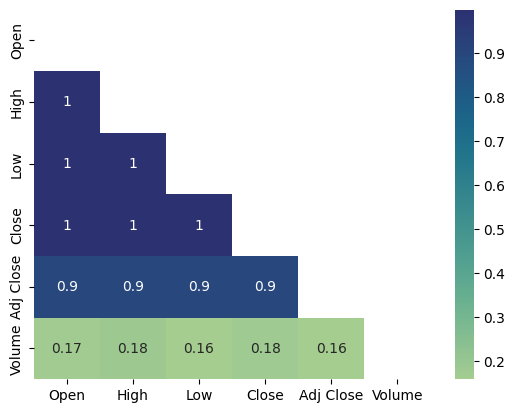

In [24]:
mask_adro = np.triu(np.ones_like(adro.corr(numeric_only=True))).astype(bool)
sns.heatmap(adro.corr(numeric_only=True), annot=True, mask=mask_adro, cmap='crest')
plt.show()

In [25]:
model = Prophet()

# Drop columns
model_df = adro.drop(['Open', 'High', 'Low', 'Volume', 'Kode', 'Adj Close'], axis=1)
model_df.rename(columns={'Close' : 'y', 'Date' : 'ds'}, inplace=True)

model_df

,ds,y
0,2008-08-01,1630.0
1,2008-08-04,1590.0
2,2008-08-05,1550.0
3,2008-08-06,1540.0
4,2008-08-07,1560.0
...,...,...
3959,2024-08-28,3530.0
3960,2024-08-29,3520.0
3961,2024-08-30,3560.0
3962,2024-09-02,3610.0


In [26]:
# Inisialisasi dan latih model dengan penyesuaian parameter
model = Prophet(
    daily_seasonality=True,
    yearly_seasonality = 'auto'
)

# Latih model
model.fit(model_df)

18:58:53 - cmdstanpy - INFO - Chain [1] start processing
18:58:56 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
# Membuat tanggal prediksi
future_prices = model.make_future_dataframe(periods=365)

# prediksi harga
predict = model.predict(future_prices)
predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4323,2025-08-31,4007.575839,3473.539686,4514.001084
4324,2025-09-01,3890.267596,3412.570336,4363.280789
4325,2025-09-02,3896.846411,3336.109803,4367.161730
4326,2025-09-03,3904.432237,3341.673994,4433.788150
4327,2025-09-04,3911.554875,3421.396166,4445.399625


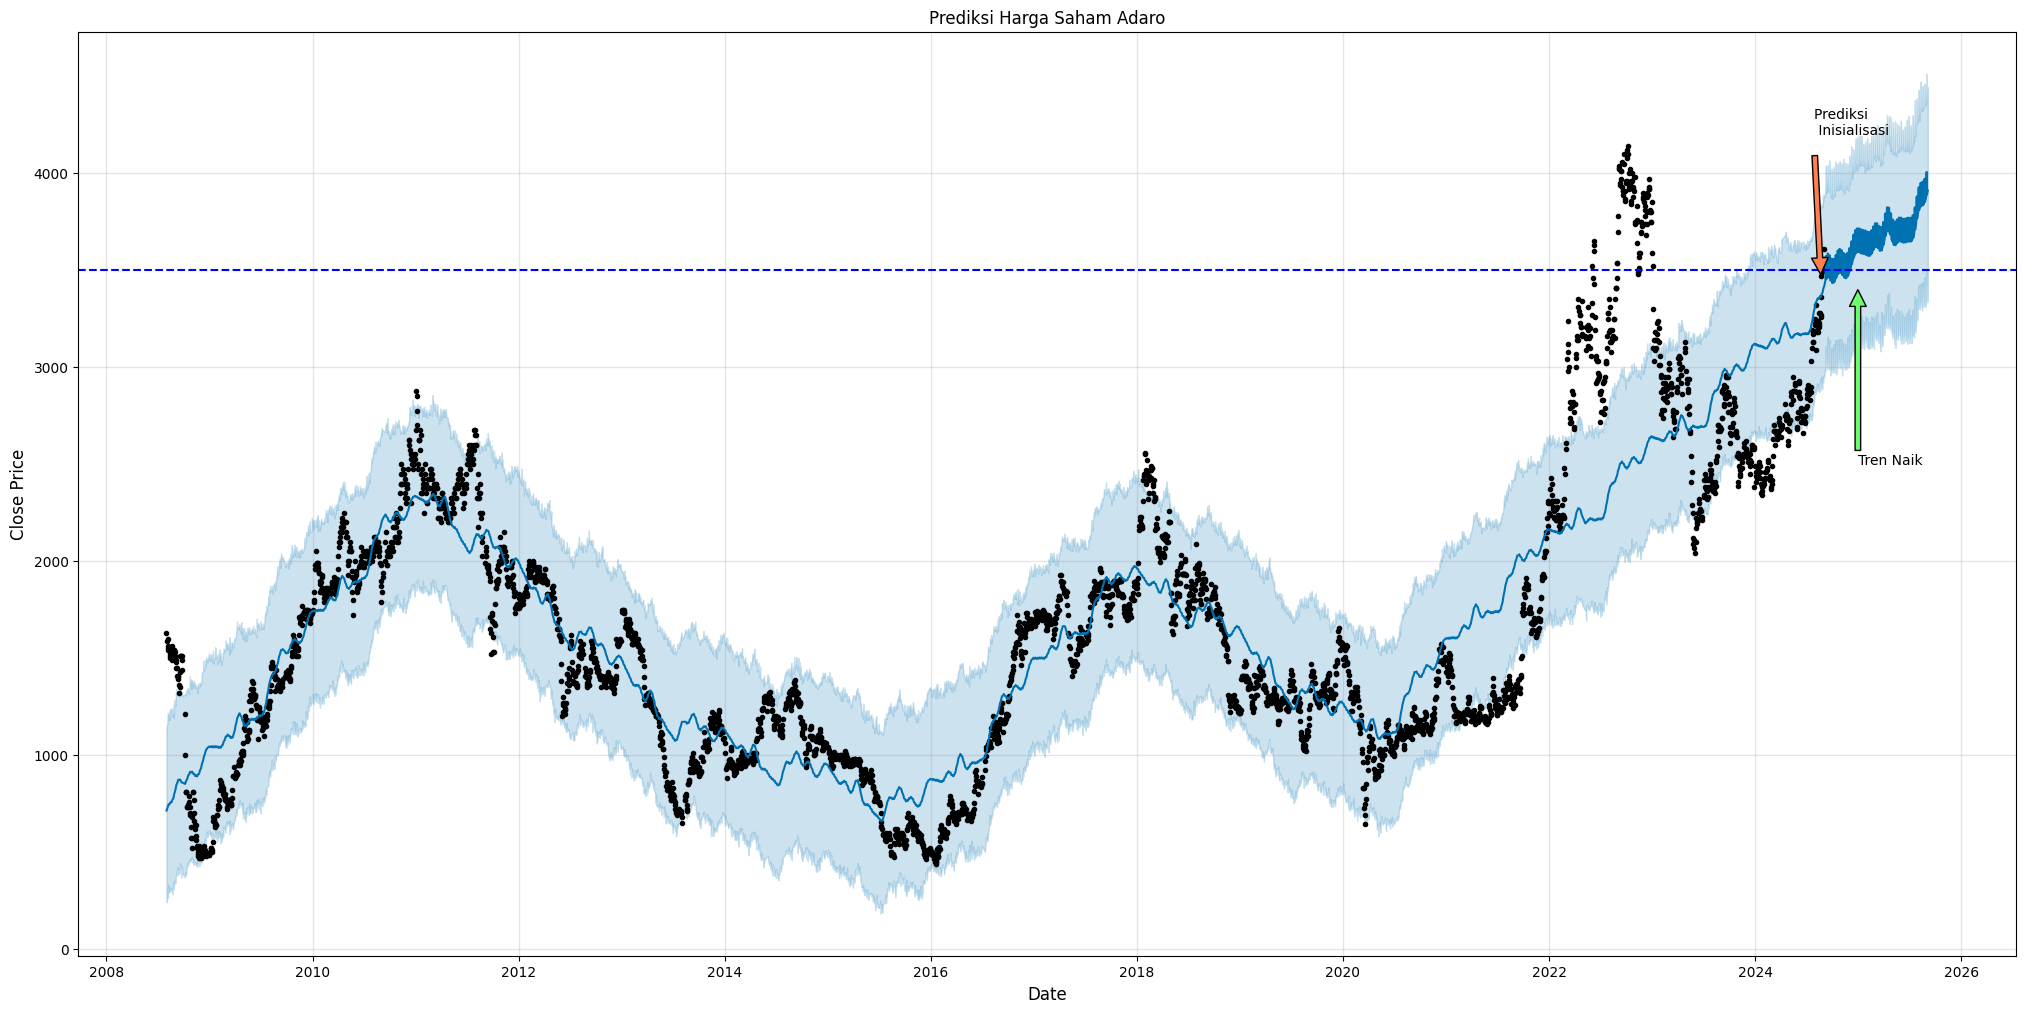

In [28]:
# Dates
start_date = dt.datetime(2024, 7, 27)
start_date1 = mdates.date2num(start_date)

trend_date = dt.datetime(2024, 12, 30)
trend_date1 = mdates.date2num(trend_date)

point_arrow = dt.datetime(2024, 8, 23)
point_arrow1 = mdates.date2num(point_arrow)

# plot
fig, ax1 = plt.subplots(figsize=(25, 12))
model.plot(predict, ax=ax1)
ax1.set_title('Prediksi Harga Saham Adaro')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Close Price', fontsize=12)

# anotasi
ax1.annotate('Prediksi \n Inisialisasi', xy=(point_arrow1, 3400), xytext=(start_date1, 4200), 
             arrowprops=dict(facecolor='#ff7f50', shrink=0.1),
             )
ax1.annotate('Tren Naik', xy=(trend_date1, 3400), xytext=(trend_date1, 2500), 
             arrowprops=dict(facecolor='#6cff6c', shrink=0.0),
             )

ax1.axhline(y=3500, color='b', linestyle='--')
plt.show()

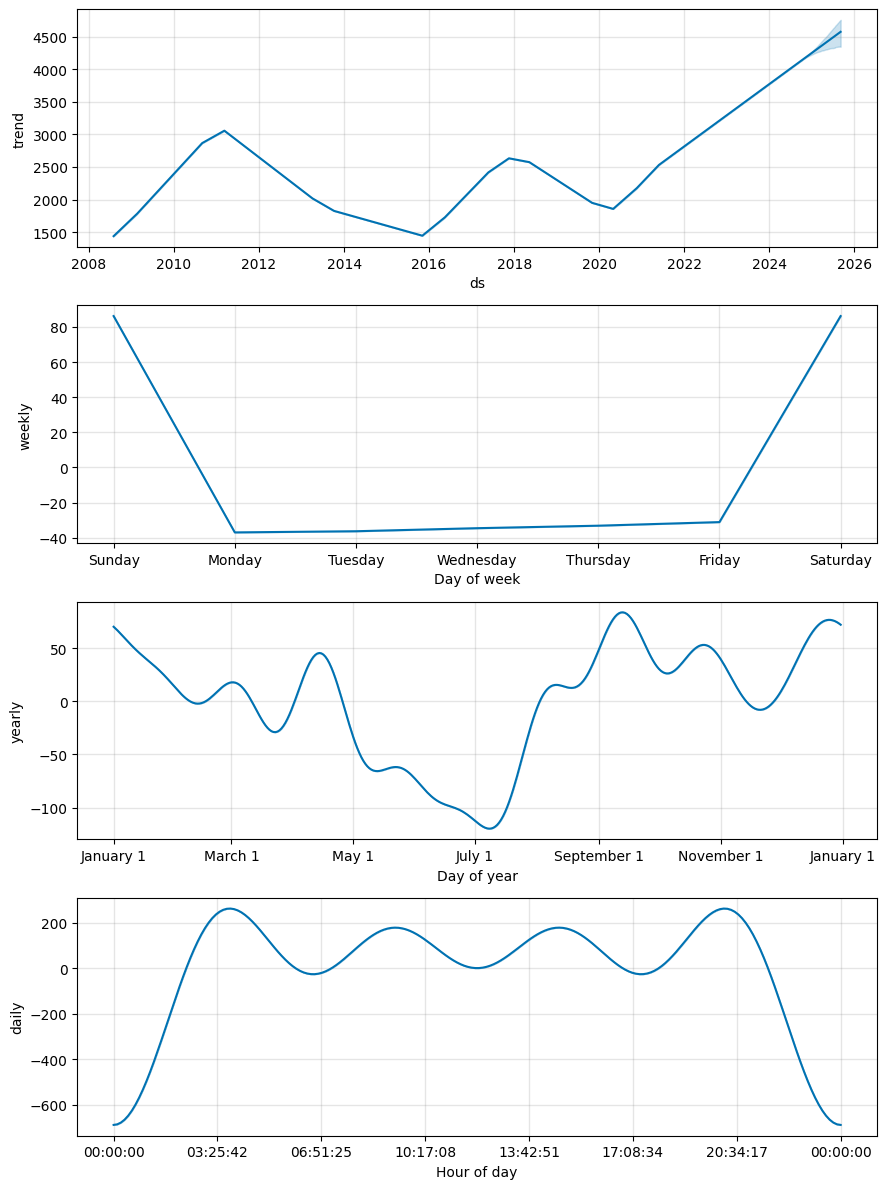

In [29]:
fig2 = model.plot_components(predict)
plt.show()

In [30]:
#Melakukan Crossvalidation dengan training data 5753 (>15 tahun), prediksi 180 (6 bulan) dan interval waktunya 120 (3 bulan)
cv_adro = cross_validation(model, initial='5753 days', period='180 days', horizon = '120 days')

  0%|          | 0/1 [00:00<?, ?it/s]

18:59:00 - cmdstanpy - INFO - Chain [1] start processing
18:59:02 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
# Melihat hasil cross validation
cv_adro.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
74,2024-08-28,3539.223987,3056.572580,3995.996531,3530.0,2024-05-07
75,2024-08-29,3545.558882,3098.346463,4045.389341,3520.0,2024-05-07
76,2024-08-30,3552.059886,3058.731939,3998.420022,3560.0,2024-05-07
77,2024-09-02,3563.894003,3058.960412,4039.116344,3610.0,2024-05-07
78,2024-09-04,3579.275412,3110.938492,4038.602139,3560.0,2024-05-07


In [32]:
# Melihat performance metrics
pm_adro = performance_metrics(cv_adro)
pm_adro.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,13 days,172852.345209,415.755151,414.173805,0.143686,0.143864,0.133974,1.000000
1,14 days,176257.092057,419.829837,418.173596,0.145004,0.147866,0.135117,1.000000
2,15 days,183186.818904,428.003293,427.472177,0.148358,0.147866,0.138082,1.000000
3,20 days,188849.489947,434.568165,433.951118,0.150687,0.149563,0.140094,0.857143
4,21 days,215841.220096,464.587150,458.232785,0.160950,0.149563,0.148560,0.714286


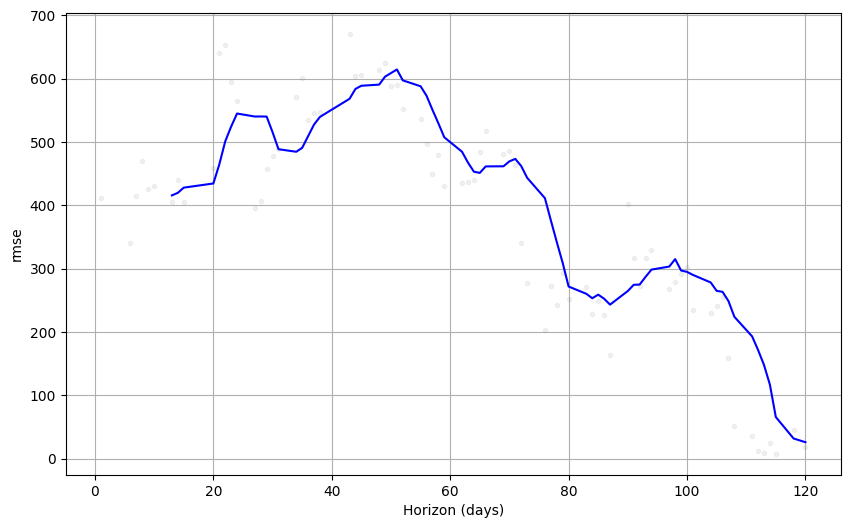

In [33]:
# Visualiasi RMSE
plot_cross_validation_metric(cv_adro, metric='rmse')
plt.show()

##### Model LSTM

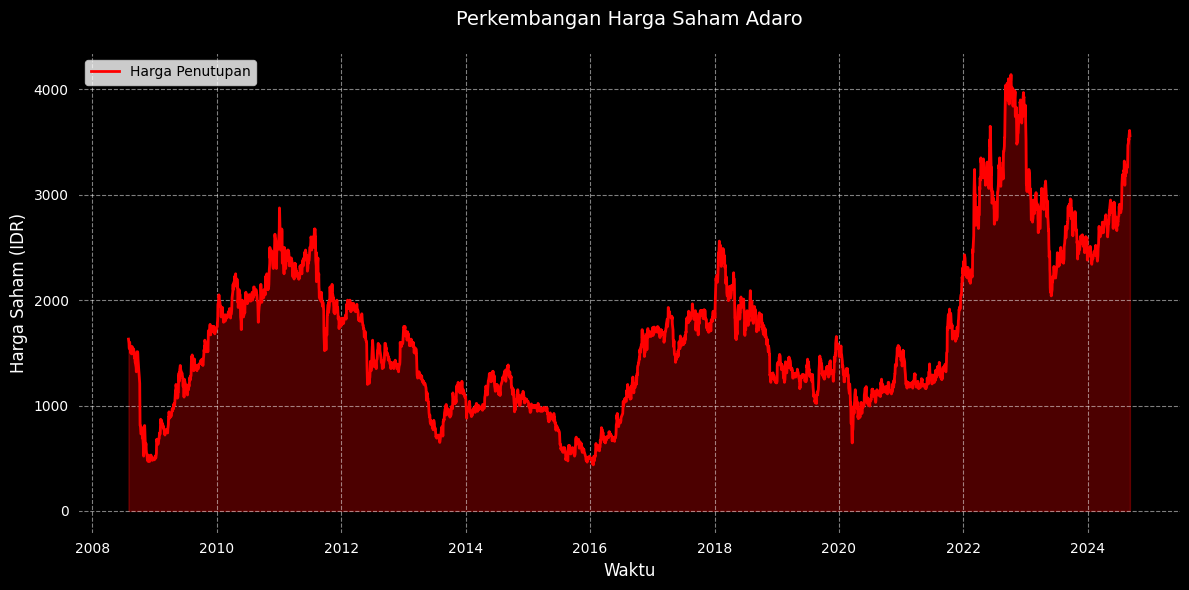

In [34]:
# Pastikan 'Date' dalam format datetime
adro['Date'] = pd.to_datetime(adro['Date'])

# Membuat grafik area
plt.figure(figsize=(12, 6))

# Menambahkan area untuk harga penutupan
plt.plot(adro['Date'], adro['Close'], color='red', linewidth=2, label='Harga Penutupan')
plt.fill_between(adro['Date'], adro['Close'], color='red', alpha=0.3)  # Mengisi area di bawah garis merah

# Mengatur layout plot
plt.title('Perkembangan Harga Saham Adaro', fontsize=14, color='white', pad=20)
plt.xlabel('Waktu', fontsize=12, color='white')
plt.ylabel('Harga Saham (IDR)', fontsize=12, color='white')

# Mengatur sumbu x dan y
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(True, color='white', linestyle='--', alpha=0.5)

# Mengatur background
plt.gca().set_facecolor('black')
plt.gcf().set_facecolor('black')

# Menampilkan legend
plt.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()

In [35]:
# Create a new dataframe with only the 'Close' column 
data_adro = adro.filter(['Close'])

# Convert the dataframe to a numpy array
adro_df = data_adro.values

# Get the number of rows to train the model on (80% of the dataset)
training_data_len = int(np.ceil(len(adro_df)) * 0.80)

training_data_len

3170

In [36]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(adro_df)

scaled_data

array([[0.32217121],
       [0.31136916],
       [0.30056711],
       ...,
       [0.84337024],
       [0.85687281],
       [0.84337024]])

In [37]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.32217121, 0.31136916, 0.30056711, 0.29786659, 0.30326762,
       0.31406967, 0.29786659, 0.28976506, 0.28706454, 0.29246557,
       0.29516608, 0.28436403, 0.29516608, 0.29516608, 0.30326762,
       0.29786659, 0.29786659, 0.29516608, 0.29516608, 0.29786659,
       0.29516608, 0.28976506, 0.28166352, 0.28436403, 0.27356198,
       0.27356198, 0.26275992, 0.26275992, 0.26005941, 0.2573589 ,
       0.24925736, 0.23845531, 0.24655685, 0.26816095, 0.28976506,
       0.28976506, 0.28976506, 0.28976506, 0.28436403, 0.27086146,
       0.20874966, 0.15203889, 0.10072914, 0.10072914, 0.10072914,
       0.07912503, 0.07912503, 0.07912503, 0.08182555, 0.08182555,
       0.09532811, 0.08722657, 0.07912503, 0.06832298, 0.07102349,
       0.0521199 , 0.03591682, 0.02241426, 0.03591682, 0.06562247])]
[0.10072913853632191]

[array([0.32217121, 0.31136916, 0.30056711, 0.29786659, 0.30326762,
       0.31406967, 0.29786659, 0.28976506, 0.28706454, 0.29246557,
       0.29516608, 0.28436403, 0.29

In [38]:
!pip install tensorflow

In [39]:
!pip install tensorflow

In [40]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [41]:
pip show tensorflow


Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\Users\Yoan Rifqi\Downloads\Project Analysis Personal\Dataset Saham Indonesia  Indonesia Stock Dataset\.venv\Lib\site-packages
Requires: tensorflow-intel
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.models import Model


In [43]:
test_size = adro[adro.Date.dt.year==2024].shape[0]
test_size

157

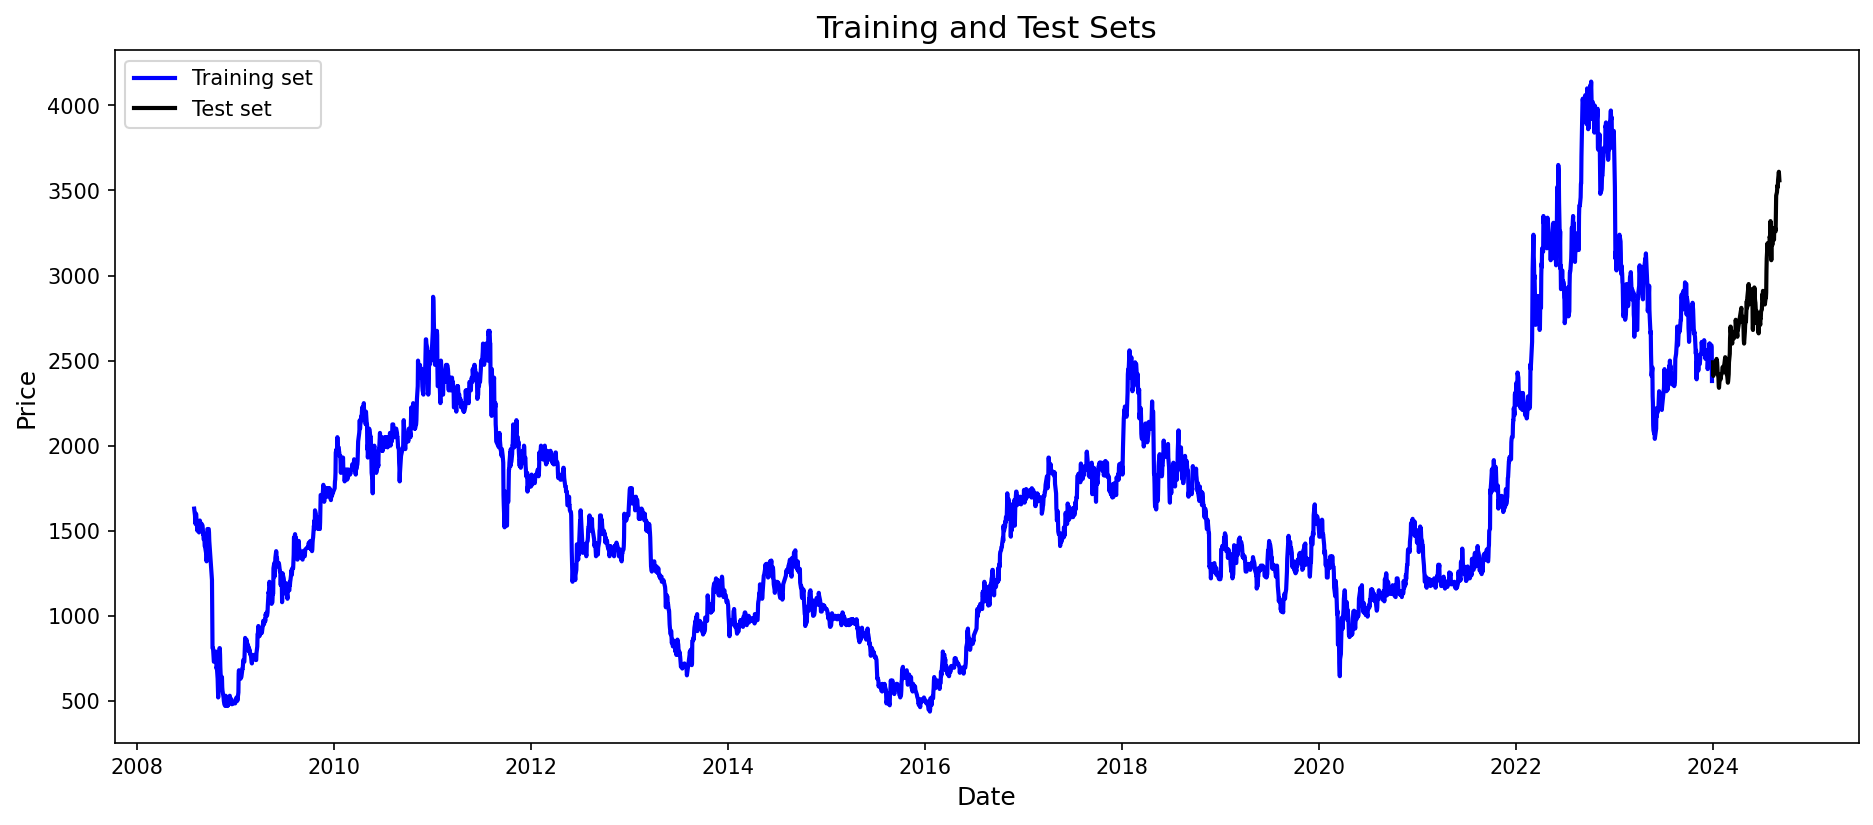

In [44]:
plt.figure(figsize=(15, 6), dpi=150)
plt.plot(adro.Date[:-test_size], adro.Close[:-test_size], color='blue', lw=2)
plt.plot(adro.Date[-test_size:], adro.Close[-test_size:], color='black', lw=2)
plt.title('Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.grid(color='white')
plt.show()

In [45]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(adro.Close.values.reshape(-1,1))

MinMaxScaler()

In [46]:
window_size = 90

In [47]:
train_data = adro.Close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [48]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-90:i, 0])
    y_train.append(train_data[i, 0])

In [49]:
test_data = adro.Close[-test_size-90:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [50]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-90:i, 0])
    y_test.append(test_data[i, 0])

In [51]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [52]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [53]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (3716, 90, 1)
y_train Shape:  (3716, 1)
X_test Shape:   (157, 90, 1)
y_test Shape:   (157, 1)


In [54]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

In [55]:
model = define_model()
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 90, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 90, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 90, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - loss: 0.0313 - val_loss: 0.0599
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.0028 - val_loss: 0.0421
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.0019 - val_loss: 0.0323
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.0015 - val_loss: 0.0260
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.0013 - val_loss: 0.0216
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.0012 - val_loss: 0.0182
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 9.5685e-04 - val_loss: 0.0155
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 9.3778e-04 - val_loss: 0.0142
Epoch 9/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 8.2221e-04 - val_loss: 0.0123
Epoch 10/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 7.8250e-04 - val_loss: 0.0115
Epoch 11/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 7.1093e-04 - val_loss: 0.0120

In [56]:
adro_result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.7601e-04
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step


In [57]:
from sklearn.metrics import mean_absolute_percentage_error

MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [58]:
print("Test Loss: ", adro_result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss:  0.0008354473393410444
Test MAPE: 0.031573796733500345
Test Accuracy: 0.9684262032664996


In [59]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

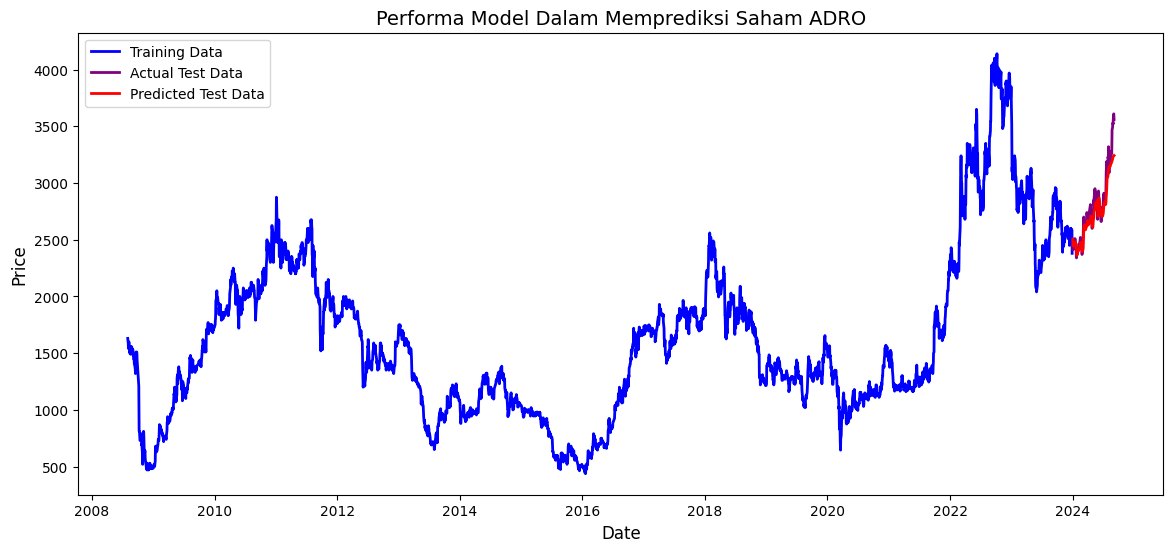

In [60]:
plt.figure(figsize=(14, 6))
plt.plot(adro['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='blue', lw=2)
plt.plot(adro['Date'].iloc[-test_size:], y_test_true, color='purple', lw=2)
plt.plot(adro['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Performa Model Dalam Memprediksi Saham ADRO', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left')
plt.grid(color='white')
plt.show()

In [61]:
model.save('lstm_stock_model.h5')

##### Model ARIMA

In [62]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [63]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [104]:
import pandas as pd

df_adro = pd.read_csv("Stock/ADRO.JK.csv")

In [105]:
# Konversi kolom 'Date' menjadi format datetime
df_adro['Date'] = pd.to_datetime(df_adro['Date'])

# Set kolom 'Date' sebagai index
df_adro.set_index('Date', inplace=True)

# Tampilkan Data
df_adro

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-08-01,1630.0,1680.0,1620.0,1630.0,625.735046,78478500.0
2008-08-04,1590.0,1630.0,1590.0,1590.0,610.379700,43837000.0
2008-08-05,1550.0,1580.0,1540.0,1550.0,595.024109,50244500.0
2008-08-06,1540.0,1570.0,1540.0,1540.0,591.185242,48545500.0
2008-08-07,1560.0,1570.0,1540.0,1560.0,598.863159,50999500.0
...,...,...,...,...,...,...
2024-08-29,3540.0,3590.0,3500.0,3520.0,3520.000000,63218700.0
2024-08-30,3540.0,3590.0,3510.0,3560.0,3560.000000,95767700.0
2024-09-02,3590.0,3650.0,3570.0,3610.0,3610.000000,96348100.0


In [106]:
df_adro = df_adro.dropna()

df_adro

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-08-01,1630.0,1680.0,1620.0,1630.0,625.735046,78478500.0
2008-08-04,1590.0,1630.0,1590.0,1590.0,610.379700,43837000.0
2008-08-05,1550.0,1580.0,1540.0,1550.0,595.024109,50244500.0
2008-08-06,1540.0,1570.0,1540.0,1540.0,591.185242,48545500.0
2008-08-07,1560.0,1570.0,1540.0,1560.0,598.863159,50999500.0
...,...,...,...,...,...,...
2024-08-28,3550.0,3560.0,3500.0,3530.0,3530.000000,50932800.0
2024-08-29,3540.0,3590.0,3500.0,3520.0,3520.000000,63218700.0
2024-08-30,3540.0,3590.0,3510.0,3560.0,3560.000000,95767700.0


In [93]:
# !pip3 install pyramid-arima (already done)
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

In [94]:
def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic','p-value']
    for value,label in zip(result,labels):
        print(label  + ': ' + str(value))
    if result[1]<=0.05:
        print('Strong evidence against the null hypothesis, Hence REJECT Ho. and The series is Stationary')
    else:
        print('Weak evidence against null hypothesis, Hence ACCEPT Ho. that the series is not stationary.')

In [96]:
adfuller_test(df_adro['Close'])

ADF Test Statistic: -19.08973614189855
p-value: 0.0
Strong evidence against the null hypothesis, Hence REJECT Ho. and The series is Stationary


In [99]:
train_data_set, test_data_set = df_adro[0:int(len(df_adro)*0.8)], df_adro[int(len(df_adro)*0.8):]

In [107]:
from pmdarima.arima import auto_arima

# Fit the auto-ARIMA model with slightly higher parameters
smodel = pm.auto_arima(df_adro['Close'], start_p=1, start_q=1,
                       test='adf',
                       max_p=3, max_q=3,  # Increase max_p and max_q moderately
                       m=12,  # Monthly seasonal pattern
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=15.67 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=51643.353, Time=0.50 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=43295.633, Time=19.81 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=48138.230, Time=24.08 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=51646.115, Time=0.38 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=44367.900, Time=2.80 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=42865.194, Time=94.18 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=54.28 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=26.41 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=51645.608, Time=11.35 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=42866.677, Time=120.23 sec


In [83]:
# Forecast
n_periods = 30*5 # for the next 3 months
s_fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True) # forecast on a daily basic
index_of_fc = pd.date_range(df_adro.index[-1], periods = n_periods, freq='D')

# make series for plotting purpose
fitted_series = pd.Series(s_fitted.values, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

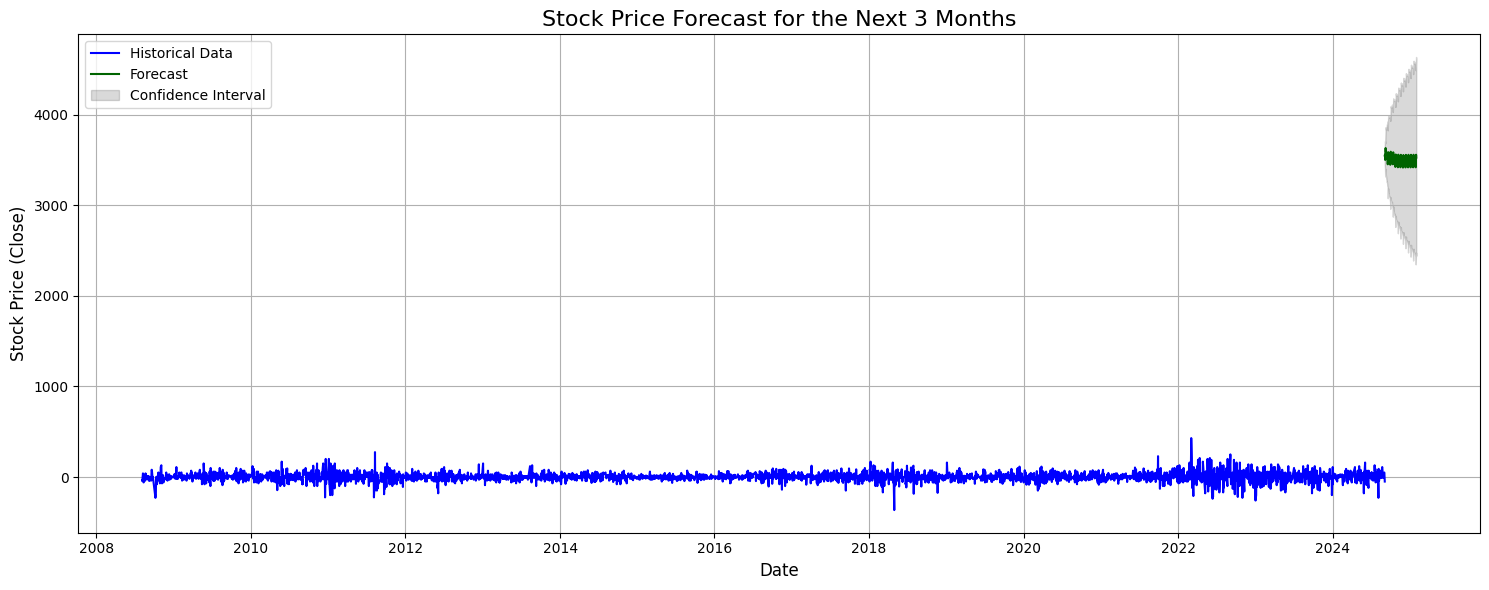

In [84]:
import matplotlib.pyplot as plt

# Plot historical data and predicted forecast
plt.figure(figsize=(15, 6))

# Plot historical data
plt.plot(df_adro.index, df_adro['Close'], label='Historical Data', color='blue')

# Plot forecast data
plt.plot(fitted_series.index, fitted_series, label='Forecast', color='darkgreen')

# Plot confidence interval
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15, label='Confidence Interval')

# Add title, labels, and legend
plt.title("Stock Price Forecast for the Next 3 Months", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Stock Price (Close)", fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

#### 2. Forecasting Saham BUMI

#### 3. Forecasting Saham BYAN

#### 4. Forecasting Saham GEMS

#### 5. Forecasting Saham INDY

#### 6. Forecasting Saham ITMG

#### 7. Forecasting Saham PTBA